**Student Name**: Jakub Niedziela
    
**Student ID**: 20224740

# Lab 4: Monte Carlo Methods

### Instructions: **TODO** tags
In this lab, you will implement Monte Carlo methods. In particular, there will be 3 main steps:
1. **Policy Evaluation**: provided an arbitrary policy $\pi$, compute its value function $v_\pi$ using MC. You will be asked to compare your results to the exact solution you will find with Dynamic Programming.
2. **On-Policy MC Control**: implement MC to find an optimal soft policy, using an $\epsilon$-greedy policy.
3. **Off-Policy MC Control**: same idea using an $\epsilon$-greedy behavior policy and learning the optimal policy.

As usual, please *read* and *run* the notebook chronologically, and fill in the **TODO**s as you encounter them.
* <span style="color:blue"> Blue **TODOs** </span> means you have to implement the TODOs in the code.
* <span style="color:red"> Red **TODOs** </span> means you have to submit an explanation (of graph/results/theory).

At each section, <span style="color:green"> (xx points) </span> indicates the number of points of the entire section (labs are graded out of 10).


### Environment
Below are the libraries we will use and the Environment.

The Environment for this lab and the next lab on tabular RL is called the **Four Rooms** Environment. It simply contains 4 rooms of fixed size $5\times5$ in our case- in which the agent can move around, as in a house. There is no noise in the dynamics, meaning that the 4 directional actions deterministically take you to the requested neighboring state. Unless stated otherwise, the agent starts from the upper left corner. It will always have to reach the terminal state in the lower right corner to get a sparse reward of $+1$; any other transition gives reward $0$. A visualization will follow.

In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import numpy as np
import gym
from gym import spaces
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm
import random
from copy import copy

In [2]:
class FourRoomsEnv(gym.Env):
    """ Small Gridworld environment with 4 rooms.
    Starting up left, goal in lower-right.
    The main challenge is that the reward is sparse (1_goal)
        """
    def __init__(self, explo_starts=False, max_steps=None):
        self.roomsize = 5
        self.height = 2*self.roomsize +1 # +1 is obstacle width
        self.width = self.height
        half = self.width // 2 # shortcut
        quarter = half // 2 # shortcut
        self.gamma = 0.9
        self.t = 0
        self.max_steps = max_steps
        self.explo_starts = explo_starts
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.height),
                spaces.Discrete(self.width)
                ))
        self.shapes = ((11,11), 4)

        self.moves = {
                0: (-1, 0),  # up
                1: (0, 1),   # right
                2: (1, 0),   # down
                3: (0, -1),  # left
                }
        self.moves_to_str = {
                0: u'↑',
                1: u'→',
                2: u'↓',
                3: u'←',
                }
        
        self.terminal = (self.height-1,self.width-1) # terminal state
        horizontal  = [(i, half) for i in range(self.width)]
        vertical    = [(half, i) for i in range(self.height)]
        self.obstacles = horizontal + vertical
        # now opening the 4 passages
        for state in [(quarter,half), (half,quarter), (half,self.height-quarter), (self.height-quarter,half)]:
            self.obstacles.remove(state)
        self.start = (0,0)
        # begin in start state
        self.reset()

    def reset(self):
        if self.max_steps is not None:
            self.t = 0
        if self.explo_starts:
            while True:
                s = self.observation_space.sample()
                if s not in self.obstacles + [self.terminal]:
                    break
            self.s = s
            #print("Random Start at S={}".format(s))
                
        else:
            self.s = self.start
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed
            self.s = self.s[0] + x, self.s[1] + y

            # Finally, setting the agent back into the grid if fallen out
            self.s = (max(0, self.s[0]), max(0, self.s[1]))
            self.s = (min(self.s[0], self.height - 1),
                      min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}
    
    def is_terminal(self, state):
        return state == self.terminal
    
    def p(self, state, action):
        assert not self.is_terminal(state)
        self.s = state
        next_state, reward, done, info = self.step(action)
        return {(next_state, reward): 1}
    
    def states(self):
        ss = []
        for i in range(self.height):
            for j in range(self.width):
                if (i,j) not in self.obstacles:
                    ss.append((i,j))
        return ss 
    
    def plot_values_policy(self, values, policy, plot_all_policy=False, cbar=True):
        """ Visualizes a policy and value function given an agent with V and policy."""
        fig, ax = plt.subplots()
        values[tuple(zip(*self.obstacles))] = None # -1
        cmap = copy(cm.get_cmap("RdYlGn"))
        # modify colormap
        l = np.array([cmap(i) for i in range(cmap.N)]).T
        l[0:2] = np.clip(l[0:2], 0,0.9)
        l[2] = np.clip(l[2], 0,0.25)
        l = l.T
        my_cmap = matplotlib.colors.ListedColormap(l, name = 'nani')
        my_cmap.set_bad('black')

        im = ax.imshow(values, cmap=my_cmap)
        for i in range(self.height):
            for j in range(self.width):
                s = (i,j)
                if s not in self.obstacles:
                    t = self.moves_to_str[policy[s]] if not self.is_terminal(s) \
                                                        and ((values[s] != 0) or (plot_all_policy)) else ""
                    text = ax.text(j, i, t,
                                   ha="center", va="center", color="w", fontsize=15)

        ax.set_title("Value function and Policy visualization")
        fig.tight_layout()
        if cbar:
            plt.colorbar(im)
        plt.show()

## 1. <span style="color:green"> (5 points) </span>  Policy Evaluation

### 1.1 Defining and visualizing the policy
Let's define and visualize an arbitrary *deterministic* policy $\pi$. We're picking a deterministic policy for ease of visualization and understanding of the learning process. 

Since we know we only need to go south and east to solve the task, let's use a policy that only picks between these two. We're plotting in green the terminal state we want to reach; later, the colors will correspond to state values. The dark squares correspond to walls.

/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_14613/3774684134.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


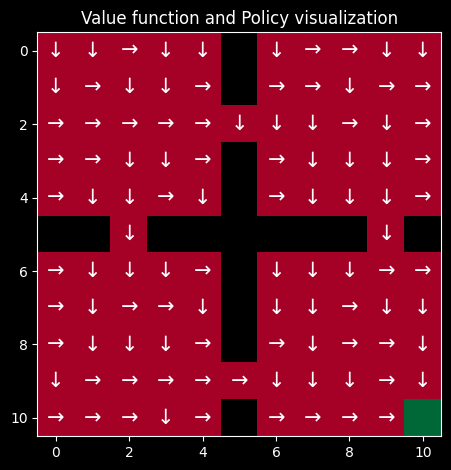

In [3]:
# Defining the environment
np.random.seed(54)
env = FourRoomsEnv()
# Defining the policy
pi = {s:np.random.choice([1,2]) for s in env.states()}
# Visualizing the environment and policy
zero_values = np.zeros(env.shapes[0])
zero_values[env.terminal] = 1
env.plot_values_policy(zero_values, pi, plot_all_policy = True, cbar=False)
np.random.seed(None)

### 1.2. <span style="color:blue"> **TODO** </span> DP Policy Evaluation
We want to evaluate $v_\pi$ for this policy. Note that we could also compute $q_\pi$, it doesn't really matter if we're not looking to extend to control!

We will first use what we know works, i.e., **Dynamic Programming**'s Policy Evaluation, then implement Monte Carlo to compare the results.

- <span style="color:blue"> **TODOs** </span>: Implement **DP_PolicyEvaluation**. This will be similar to the Policy and Value Iteration agents from the previous lab, we're providing an MDP as input and implement a `run` method to compute the values. Instead of a dictionary as before, we will now use a **numpy array** to store the $v$ and $q$ from now on, as it is more efficient, more fit for this environment, and easier to visualize. The policy $\pi$ is a dictionary here, but it makes little practical difference. You can use an In-Place algo, or not, however you want.

In [4]:
class DP_PolicyEvaluation():
    def __init__(self, mdp):
        self.mdp = mdp
        self.gamma = self.mdp.gamma
        self.V = np.zeros(self.mdp.shapes[0])
        
    def run(self, pi, delta):
        """ Runs Policy evaluation for a given policy. 
        No returns expected, but use the self.V array to store your values so we can plot it.
        Parameters
        ----------
        pi: dict
            Policy to Evaluate. Comes as a dictionary of state:action keys.
        delta: float
            Precision at which Policy Evaluation should be stopped.
        """
        while True:
            diff = 0
            for start in self.mdp.states():
                if self.mdp.is_terminal(start):
                    continue
                current_value = self.V[start]
                action = pi[start]
                new_val = 0
                for end, prob in self.mdp.p(start, action).items():
                    (end, r) = end
                    new_val += prob * (r + self.gamma * self.V[end])
                self.V[start] = new_val
                diff = max(diff, abs(new_val - current_value))
                
            if diff < delta:
                break

Let's run the Policy Evaluation and visualize the estimated values of $\pi$:

/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_14613/3774684134.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


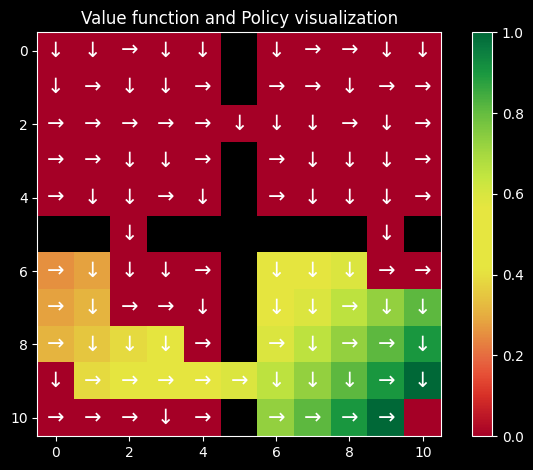

In [5]:
agent_dp = DP_PolicyEvaluation(env)
agent_dp.run(pi, delta=1e-3)
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True, cbar=True)

<span style="color:red"> **TODO** </span>: Shortly **comment** your result.

In this policy evaluation function, we can see that more than half of tiles have values of 0. Obviously the closer the tile is to the terminal state, the higher the value of tile, as long as it is possible to reach the end from givent states. That's why most of states have value of 0, as at some point the agent gets stuck with the move, which is also because the policy here is deterministic and there is no noise. We can obtain the positive values for some tiles (green, yellow and orange) because the algorithm works recursively. It starts updating the values starting from states closest to the terminal state and spreads the values across the grid. At some point when there is no possible transistion given the policy pi, the values stop updating. Hence the red tiles.

### 1.2.  <span style="color:blue"> **TODO** </span> Monte Carlo Policy Evaluation

We will now find $v_\pi$ simply by interacting with the environment, using MC. We will need a different `argmax` function from the one in the `numpy` library, because it always returns the first occurence of the max, while we need a random choice of the occurences. 

In [6]:
# Nothing to do in this cell.
def allmax(a):
    """ Returns all occurences of the max """
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

def my_argmax(v):
    """ Breaks ties randomly. """
    return random.choice(allmax(v))

From here on, we are shifting from the Dynamic Programming framework to the more general Reinforcement Learning framework of **Agent-Environment interactions**. Our abstraction for such agents is that they need to be able to `act` given a state, i.e., sample from their policy; and `learn` given a transition $\left(s,a,r,s^\prime\right)$. For practical purposes, we also need to `reset` the agent to $0$ learning, getting ready for another round of learning; similar to the Environment's `reset` method, getting ready for a new episode.

- <span style="color:red"> **TODO** </span>: **Remind** why MC Policy Evaluation should converge? <br/> 

The MC policy evaulation should converge due to the law of large numbers, as we use infinite (very large) number of episodes.

- <span style="color:blue"> **TODO** </span>: **Implement** MC Policy Evaluation provided the policy $\pi$ we have already evaluated. The policy is now given to the agent as we build it (in `__init__`), since we want the agent to interact using it. Please use `self.V` to store your state value estimates.

In [7]:
class MonteCarloPolicyEval():
    """ Given a policy, uses that policy to act in the environment.
    Learns its V value.
    """
    def __init__(self, env_shapes, pi, epsilon=0.1, gamma=0.9, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes

        self.gamma = gamma
        self.epsilon = epsilon
        self.V = np.zeros(self.input_shape) # Array of value estimates.
        self.pi = pi
        # You can add or remove things in here, if needed
        self.R = np.zeros(self.input_shape)
        self.N = np.zeros(self.input_shape)
        
    def reset(self):
        """ 
        Reset method of your Agent. No inputs, no returns.
        """
        self.G = 0
        self.episode = []

    def act(self, s):
        """ Action in the environment, i.e. sample from our policy.
        Parameters
        ----------
        s: tuple
            State from which to give out an action
        Returns
        -------
        action : int
            Action to perform in the env
        """
        return self.pi[s]
        
    def learn(self, s, a, r, s_, d=False):
        """ MC learning the policy value from a transition. 
        Parameters
        ----------
        s, a, r, s_, d: tuple, int, float, tuple, bool
            Transition in the environment.
            From state s, taking action a, obtaining reward r and ending up in state s_
            d is the done signal, indicating if s_ is terminal.
        """

        self.episode.insert(0, (s, a, r, s_))

        if d:
            for step in self.episode:
                (s, a, r, s_) = step
                self.G = self.G * self.gamma + r
                self.N[s] += 1
                self.R[s] += self.G
            
            self.V = np.divide(self.R, self.N, out=np.zeros_like(self.R), where=self.N!=0)

            self.reset()


Now we can implement our first true learning loop! Using the [gym](https://gym.openai.com/) framework again for agent-env interactions, here's how we expect a learning loop to look like for a single episode:
```
state = env.reset()
while True:
  action = agent.act()
  next_state, reward, done, info = env.step(action)
  agent.learn(state, action, reward, next_state, done)

  if done:
    break
env.close()
```

This is what is implemented below, with a bit more to plot things out.

In [8]:
# Learning and visualization. Nothing to do here.
def learn_v_pi(agent, env, n_episodes):
    evaluations_history = []
    agent.reset()
    first = True
    # Training phase
    for ep in range(n_episodes):
        s = env.reset()
        while True: # step limit implemented in Env
            action = agent.act(s) # must be = pi[s]
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_
        if first and np.any(agent.V != 0):
            print("V visualization after the first rewarding episode observed - episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
            first = False
        if not first and not ep % 200:
            print("V visualization after episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
        
    print("Final V visualization: ")
    env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
    env.close()

Since we chose a deterministic policy, we actually only need Exploring Starts to go over every single state once in order to get a perfect estimate. However, we will proceed as if $\pi$ was not deterministic, and without assuming control over the initial states - we know they are random, but no more.

We need all states to be sampled. Since there are around $100$ non-terminal states, we can be sure that all will most likely have been selected once if we run $1000$ episodes.

V visualization after the first rewarding episode observed - episode 6:


/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_14613/3774684134.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


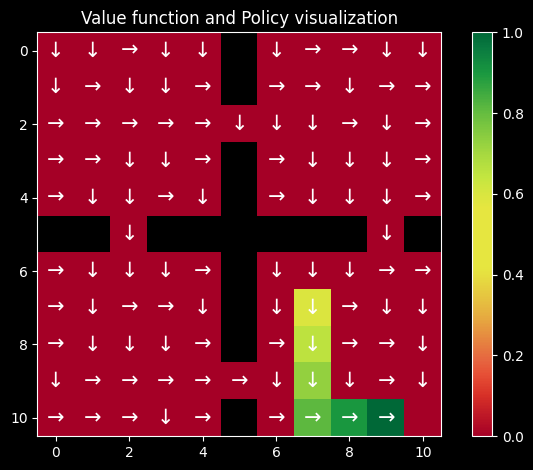

V visualization after episode 200:


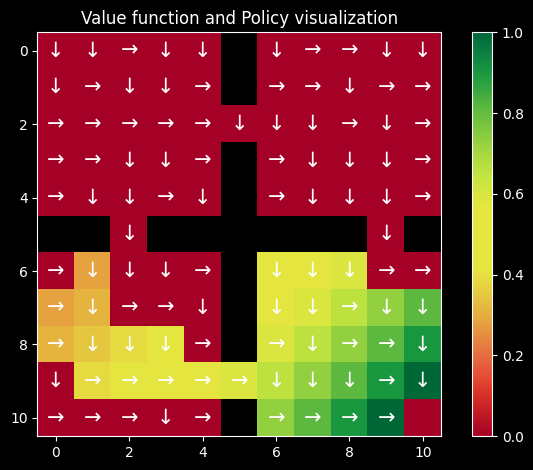

V visualization after episode 400:


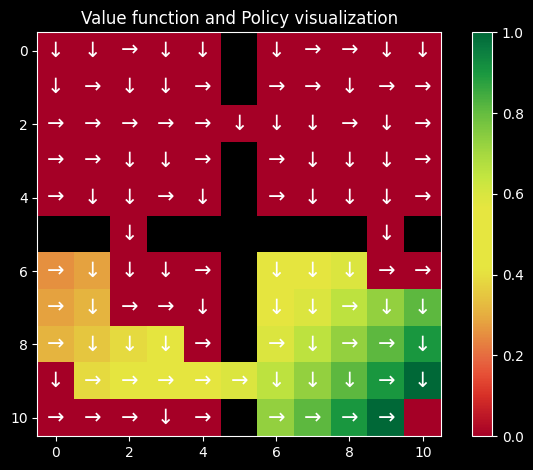

V visualization after episode 600:


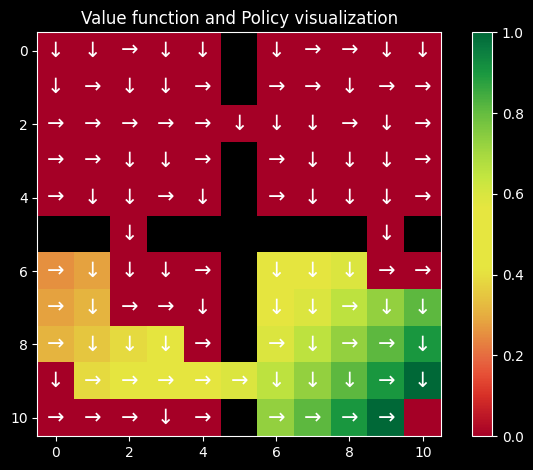

V visualization after episode 800:


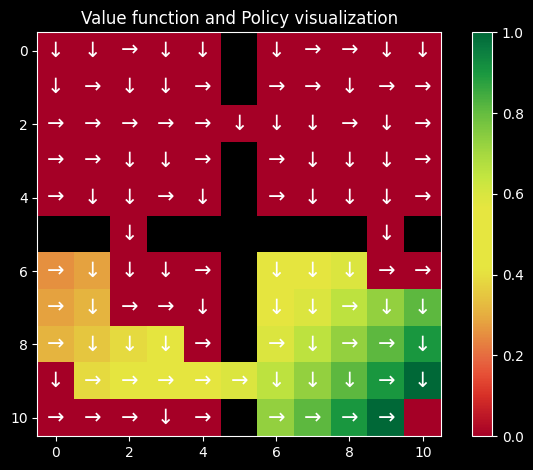

Final V visualization: 


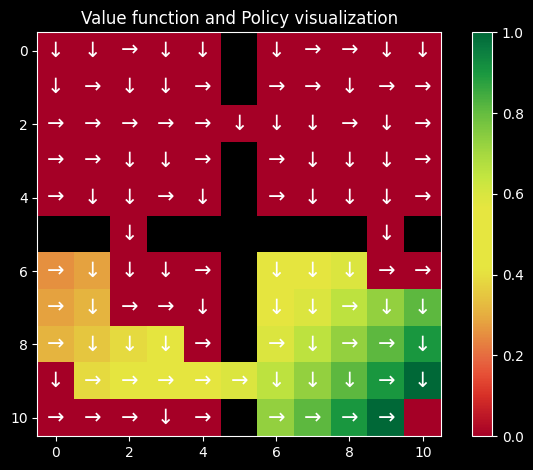

In [9]:
env = FourRoomsEnv(explo_starts=True, max_steps = 50)
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'gamma': env.gamma,
    'pi' : pi
}
agent_mc = MonteCarloPolicyEval(**d)
learn_v_pi(agent_mc, env, 1000)

Reminder, to compare with your DP solution:

/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_14613/3774684134.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


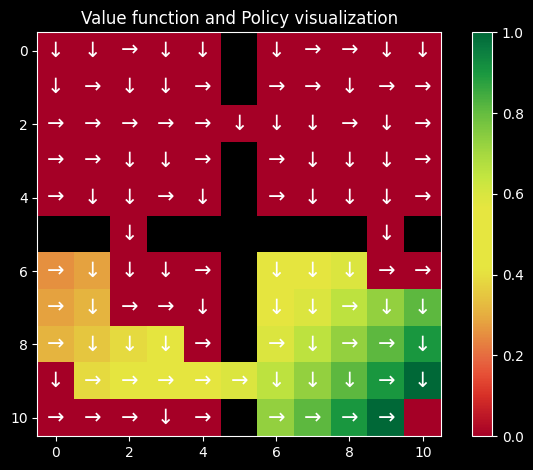

In [10]:
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True)

<span style="color:red"> **TODO** </span>: Shortly **compare** your results and the methods.

The results of both methods are the same. Both converge to the values that they should under the law of large numbers.

When it comes to the value function estimation using DP, we know the probabilities, and rewards for each state action pair. Thanks to this the algorithm works faster in obtaining value function. 

In the second case - every visit MC prediction, the algorithm simulates actions of agent and obtains value function in this way. It is slower due to the simulation part - agent needs to take action, observe the environment and obtain the reward.

## 2. <span style="color:green"> (5 points) </span>  Monte Carlo Control
### 2.1. <span style="color:blue"> **TODO** </span> On-Policy MC
Policy Evaluation is cool, but the most interesting problem to solve is the Control problem, where we need to find an optimal policy. However, we drastically changed the framework: from perfect access to the MDP dynamics, we now want to learn an optimal policy only from Agent-Environment interactions.

- <span style="color:red"> **TODO** </span> **Remind** how MC approaches the Control problem to converge. <br/> 

We can ensure the convergence of MC by having large enough number of episodes. Also there is a second way called exploring starts.
- <span style="color:red"> **TODO** </span> **Remind** how on-policy MC works *without exploring starts*.<br/> 

When we choose not to go for exploring starts algorithm, on-policy MC works by using an epsilon-soft policy. This ensures the improvement on every step.
- <span style="color:blue"> **TODO** </span> **Implement** $\epsilon$-greedy MC for on-policy Control.

In [11]:
class EGMonteCarlo():
    """ Tabular method that keeps the Q-values of all the possible
    state-action pairs; updates on an episode-wise schedule
    On-Policy version using epsilon-greedy
    """
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.Q = np.zeros((*self.input_shape, self.n_actions)) # Q value estimates. Access a state with Q[s] and state action pair with Q[s][a]
        self.N = np.zeros((*self.input_shape, self.n_actions))
        self.R = np.zeros((*self.input_shape, self.n_actions))
        self.gamma = gamma
        self.epsilon = epsilon
        self.pi = np.full((*self.input_shape, self.n_actions), 1 / self.n_actions)
        self.reset()

    def reset(self):
        self.G = 0
        self.episode = []

    def act(self, s):

        return np.random.choice(np.arange(self.n_actions), p=self.pi[s])

    def learn(self, s, a, r, s_, d=False):
        
        self.episode.insert(0, (s, a, r, s_))

        if d:
            for step in self.episode:
                (s, a, r, s_) = step
                self.G = self.G * self.gamma + r
                self.N[s][a] += 1
                self.R[s][a] += self.G
            
                self.Q = np.divide(self.R, self.N, out=np.zeros_like(self.R), where=self.N!=0)

                a_star = my_argmax(self.Q[s])

                for a in range(self.n_actions):
                    self.pi[s] = self.epsilon / self.n_actions

                    self.pi[s][a_star] = 1 - self.epsilon + self.epsilon / self.n_actions
                    

            self.reset()

In [12]:
def view_train_agent(agent, env, n_episodes):
    """ Returns the steps_history of the agent"""
    evaluations_history = []
    view = [0,1,3,5,10,100,500]
    agent.reset()
    # Training phase
    steps_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        t = 0
        s = env.reset()
        while True:
            action = agent.act(s)
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_
            t += 1
        if ep in view:
            print("Best Q and action after episode {}:".format(ep))
            best_qs = np.max(agent.Q, axis=-1)
            greedy_policy = np.argmax(agent.Q, axis=-1)
            env.plot_values_policy(best_qs, greedy_policy)

        steps_history[ep] = t
        
    
    print("Final Q and policy:")
    best_qs = np.max(agent.Q, axis=-1)
    greedy_policy = np.argmax(agent.Q, axis=-1)
    env.plot_values_policy(best_qs, greedy_policy)
    env.close()
    return steps_history[1:] # First is totally random

Since there is now stochastic exploration, the episodes will all reach the terminal state, if given enough time. We can remove both the step limit and Exploring Starts.

Best Q and action after episode 0:


/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_14613/3774684134.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


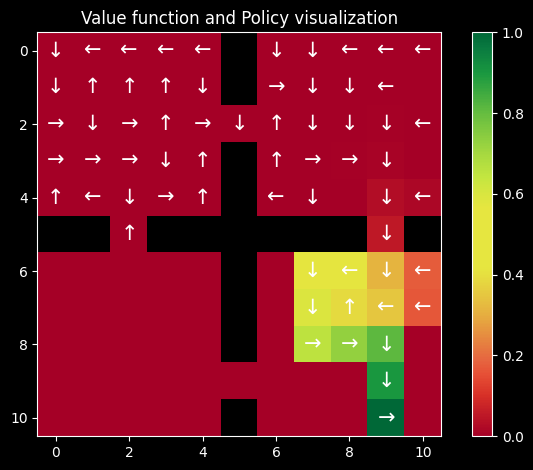

Best Q and action after episode 1:


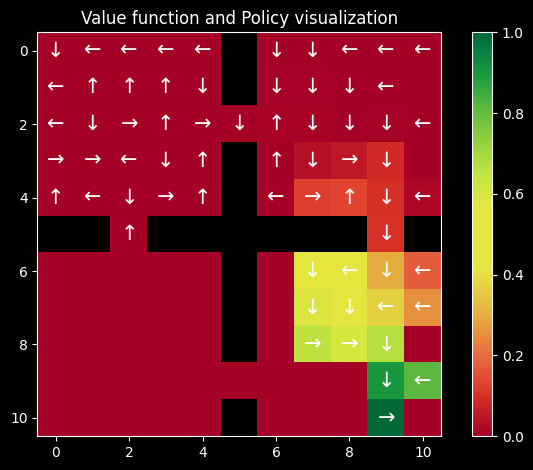

Best Q and action after episode 3:


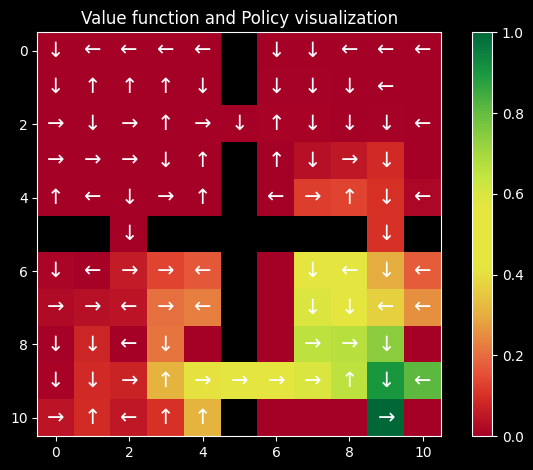

Best Q and action after episode 5:


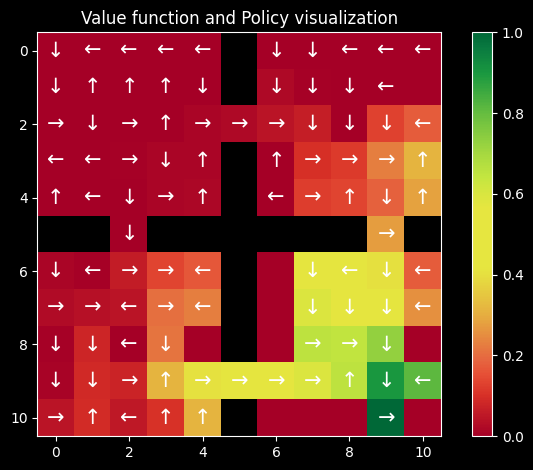

Best Q and action after episode 10:


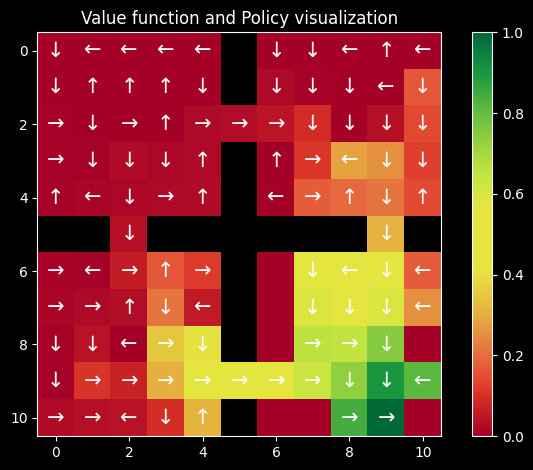

Best Q and action after episode 100:


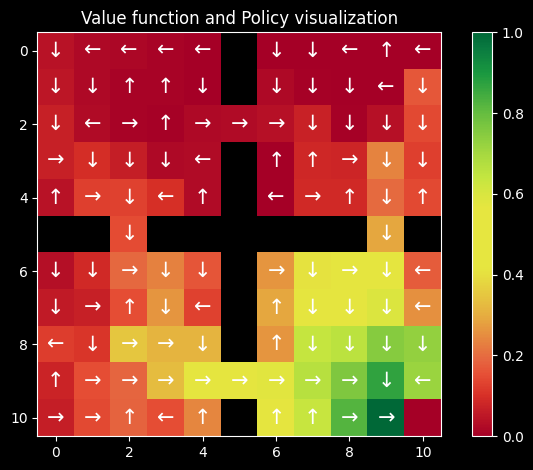

Best Q and action after episode 500:


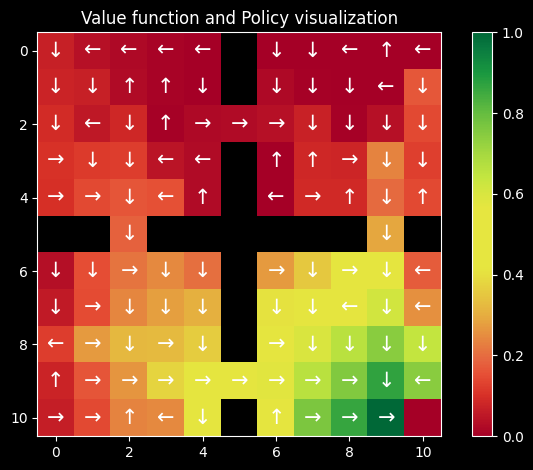

Final Q and policy:


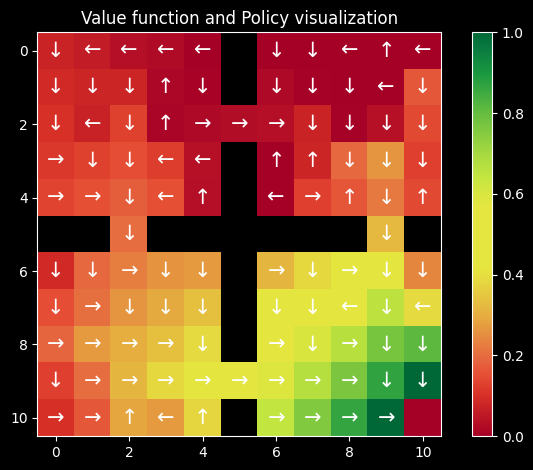

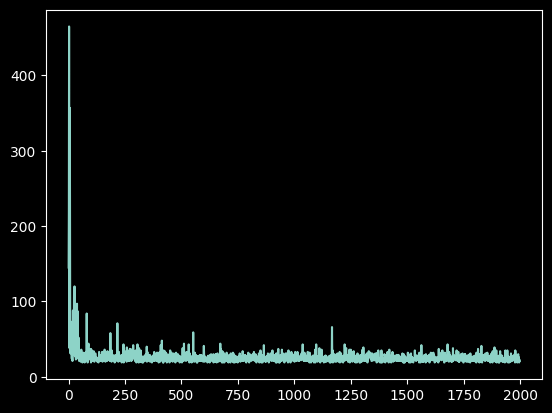

In [13]:
env = FourRoomsEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'gamma': env.gamma,
}
agent = EGMonteCarlo(**d)
perf_EG = view_train_agent(agent, env, 2000)
plt.plot(perf_EG)

<span style="color:red"> **TODO** </span>: **Explain** your understanding of how MC updates its values.**Comment** the results you obtained and the evolution of the learnt policy.

MC updates its values by taking the average of values calculated for the state, in case of first visit - the values during first visit in given episode, or in case of every visit - average of values during each visit to the state.

Agent finds optimal policy, as finally he reaches the target. We can also see it on the last plot as the number of needed steps drastically decreases. Also as agent visits each state many times, we gradually get better estimates of value function for all states.

## 2.2. <span style="color:blue"> **TODO** </span> Off-Policy Monte Carlo
On-Policy Monte Carlo without Exploring starts is limited to soft policies. Off-Policy MC offers the promise of learning an optimal policy -and optimal values- by using a behavior policy $b$ different from the learnt policy $\pi$. In our case, we will follow the course and choose $b$ to be an $\epsilon$-greedy policy according to our $Q$ estimates, while the learnt $\pi$ policy is the true optimal policy.
- <span style="color:blue"> **TODO** </span> **Implement** MC for Off-policy Control as discussed. Use the same formalism as the On-Policy agent above.

In [14]:
class OffMonteCarloIS(EGMonteCarlo):
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, **kwargs):
        super().__init__(env_shapes, epsilon, gamma, **kwargs)
        self.pi = np.argmax(self.Q, axis=-1)
        self.C = np.zeros((*self.input_shape, self.n_actions))
        self.b = np.full((*self.input_shape, self.n_actions), 1/self.n_actions)


    def reset(self):
        self.G = 0
        self.W = 1
        self.episode = []
        

    def act(self, s):
        return np.random.choice(np.arange(self.n_actions), p=self.b[s])
    

    def learn(self, s, a, r, s_, d=False):
        self.episode.insert(0, (s, a, r, s_))

        if d:
            for step in self.episode:
                (s, a, r, s_) = step
                self.G = self.G * self.gamma + r

                self.C[s][a] += self.W
                self.Q[s][a] += self.W / self.C[s][a] * (self.G - self.Q[s][a])

                a_star = my_argmax(self.Q[s])

                self.pi[s] = a_star

                self.b[s] = self.epsilon / self.n_actions

                self.b[s][a_star] = 1 - self.epsilon + self.epsilon / self.n_actions

                if a != a_star:
                    break
                
                self.W = self.W / self.b[s][a]

            self.reset()

            


Best Q and action after episode 0:


/var/folders/0z/9gp9vcnj7tb2g040j_v9z31r0000gn/T/ipykernel_14613/3774684134.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


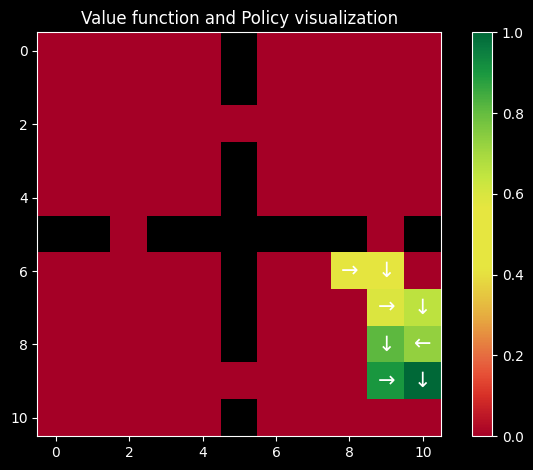

Best Q and action after episode 1:


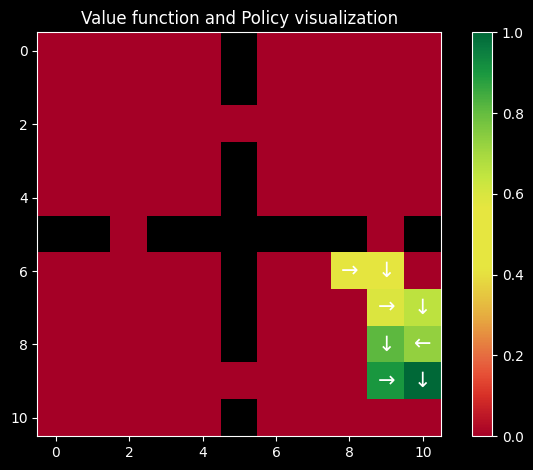

Best Q and action after episode 3:


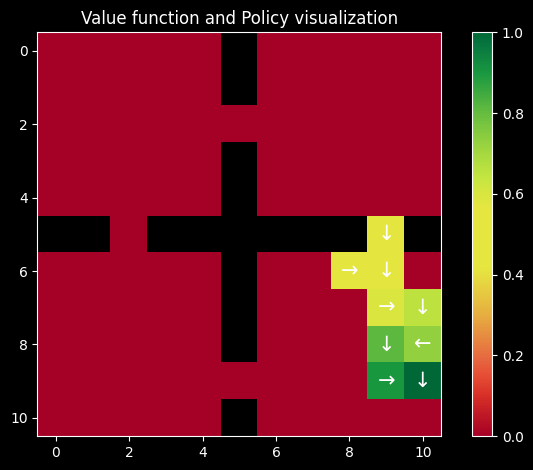

Best Q and action after episode 5:


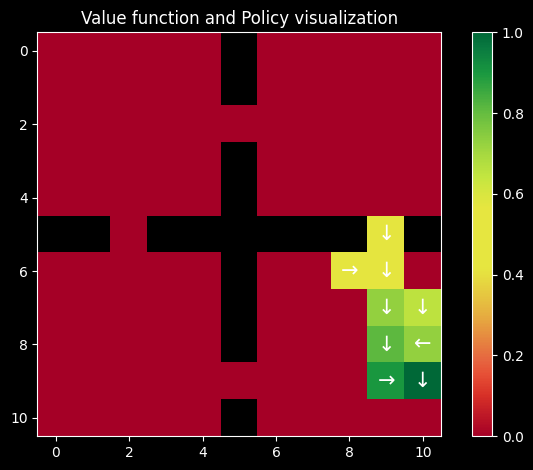

Best Q and action after episode 10:


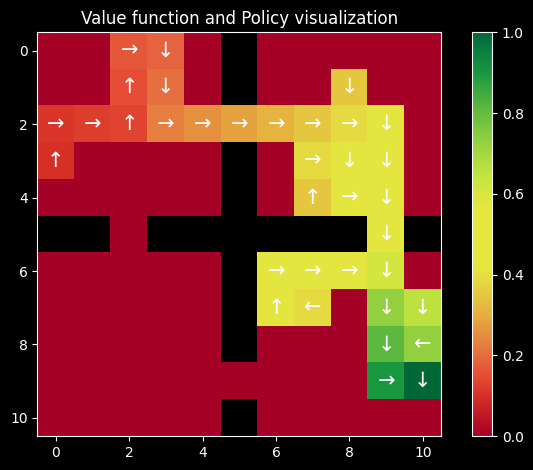

Best Q and action after episode 100:


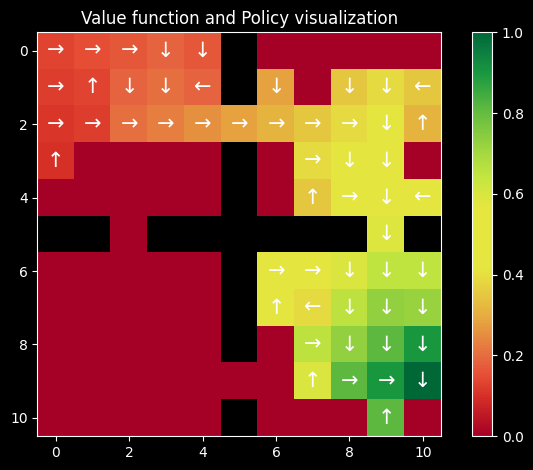

Best Q and action after episode 500:


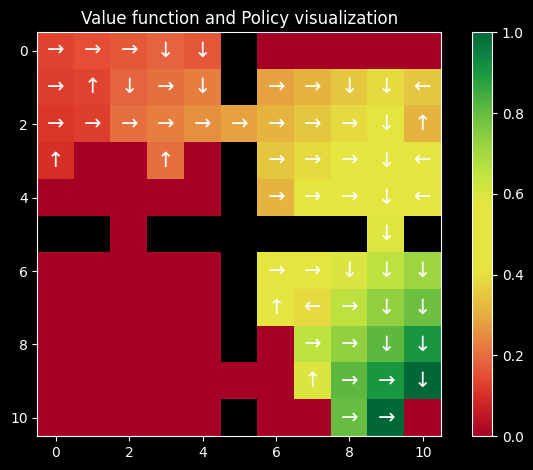

Final Q and policy:


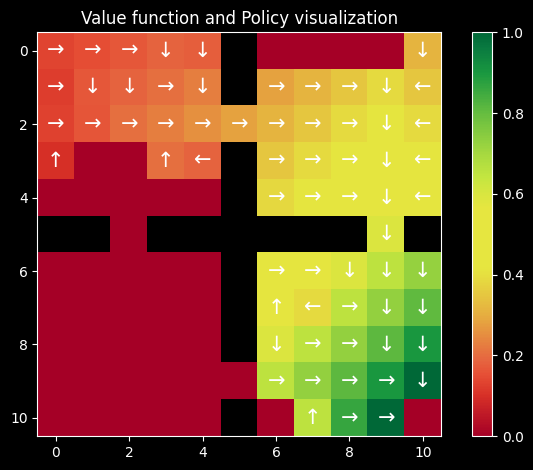

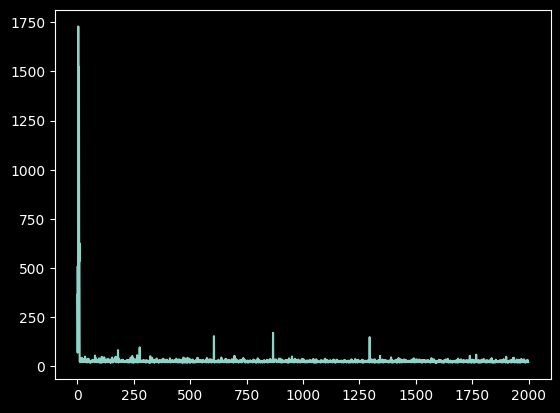

In [15]:
env = FourRoomsEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'gamma': env.gamma,
}
agent = OffMonteCarloIS(**d)
perf_off = view_train_agent(agent, env, 2000)
plt.plot(perf_off)

<span style="color:red"> **TODO** </span>: **Explain** briefly the difference in approach from On to Off policy MC. **Comment** the results you obtained and the evolution of the learnt policy.

In the code for Off policy MC agent does not follow the final policy, but rather the soft policy b. The soft policy b is updated in each iteration, giving the highest probability to action which yields the highest value, but other actions are also possible. The final policy is calculated after following 2000 episodes with soft policy b, by taking the argmax action of Q table for each state.

As we can see on the plots, the agent in the end finds the optimal policy as he reaches the final destination. As number of episodes increases the agent explores more states, has more knowledge of the behaviour of environment.